In [1]:
!pip uninstall tensorflow -y
!pip install "tensorflow<=2.4.1"

Found existing installation: tensorflow 2.6.0
Uninstalling tensorflow-2.6.0:
  Successfully uninstalled tensorflow-2.6.0
     |████████████████████████████████| 394.3 MB 12 kB/s 
     |████████████████████████████████| 462 kB 89.4 MB/s 
     |████████████████████████████████| 3.8 MB 79.9 MB/s 
     |████████████████████████████████| 2.9 MB 66.2 MB/s 
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.41.0
    Uninstalling grpcio-1.41.0:
      Successfully uninstalled grpcio-1.41.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import os
os.chdir('/content/gdrive/MyDrive/Custom_Mask_RCNN/Mask_RCNN/samples/Fruit')

In [4]:
!pwd

/content/gdrive/MyDrive/Custom_Mask_RCNN/Mask_RCNN/samples/Fruit


In [14]:
import os
import sys
import random
import json
import skimage.draw
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to Fruit trained weights
Fruit_WEIGHTS_PATH = "/content/gdrive/MyDrive/Custom_Mask_RCNN/mask_rcnn_fruit_0070.h5"  # TODO: update this path
#Fruit_WEIGHTS_PATH = "/content/gdrive/MyDrive/Custom_Mask_RCNN/Mask_RCNN/logs/mask_rcnn_fruit_0010.h5"  # TODO: update this path
Fruit_DIR = "/content/gdrive/MyDrive/Custom_Mask_RCNN/Mask_RCNN/samples/Fruit/dataset"  # TODO: update this path

source = 'Fruit'  # TODO: update this name

In [15]:
class FruitDataset(utils.Dataset):
    # Load annotations
    # Labelme Image Annotator v = 3.16.7 
    # different version may have different structures
    # besides, labelme's annotation setup one file for 
    # one picture not for all pictures
    # and this annotations  are all dicts after Python json load 
    # {
    #   "version": "3.16.7",
    #   "flags": {},
    #   "shapes": [
    #     {
    #       "label": "balloon",
    #       "line_color": null,
    #       "fill_color": null,
    #       "points": [[428.41666666666674,  875.3333333333334 ], ...],
    #       "shape_type": "polygon",
    #       "flags": {}
    #     },
    #     {
    #       "label": "balloon",
    #       "line_color": null,
    #       "fill_color": null,
    #       "points": [... ],
    #       "shape_type": "polygon",
    #       "flags": {}
    #     },
    #   ],
    #   "lineColor": [(4 number)],
    #   "fillColor": [(4 number)],
    #   "imagePath": "10464445726_6f1e3bbe6a_k.jpg",
    #   "imageData": null,
    #   "imageHeight": 2019,
    #   "imageWidth": 2048
    # }
    # We mostly care about the x and y coordinates of each region
    def load_dataset(self, dataset_dir, subset):
        """
        Load a subset of the dataset.
        source: coustomed source id, exp: load data from coco, than set it "coco",
                it is useful when you ues different dataset for one trainning.(TODO)
                see the prepare func in utils model for details
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)
 
        filenames = os.listdir(dataset_dir)
        jsonfiles,annotations=[],[]
        for filename in filenames:
            if filename.endswith(".json"):
                jsonfiles.append(filename)
                annotation = json.load(open(os.path.join(dataset_dir,filename)))
                # Insure this picture is in this dataset
                imagename = annotation['imagePath']
                if not os.path.isfile(os.path.join(dataset_dir,imagename)):
                    continue
                if len(annotation["shapes"]) == 0:
                    continue
                # you can filter what you don't want to load
                annotations.append(annotation)
                
        print("In {source} {subset} dataset we have {number:d} annotation files."
            .format(source=source, subset=subset,number=len(jsonfiles)))
        print("In {source} {subset} dataset we have {number:d} valid annotations."
            .format(source=source, subset=subset,number=len(annotations)))
 
        # Add images and get all classes in annotation files
        # typically, after labelme's annotation, all same class item have a same name
        # this need us to annotate like all "ball" in picture named "ball"
        # not "ball_1" "ball_2" ...
        # we also can figure out which "ball" it is refer to.
        labelslist = []
        for annotation in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            shapes = [] 
            classids = []
 
            for shape in annotation["shapes"]:
                # first we get the shape classid
                label = shape["label"]
                if labelslist.count(label) == 0:
                    labelslist.append(label)
                classids.append(labelslist.index(label)+1)
                shapes.append(shape["points"])
            
            # load_mask() needs the image size to convert polygons to masks.
            width = annotation["imageWidth"]
            height = annotation["imageHeight"]
            self.add_image(
                source,
                image_id=annotation["imagePath"],  # use file name as a unique image id
                path=os.path.join(dataset_dir,annotation["imagePath"]),
                width=width, height=height,
                shapes=shapes, classids=classids)
 
        print("In {source} {subset} dataset we have {number:d} class item"
            .format(source=source, subset=subset,number=len(labelslist)))
 
        for labelid, labelname in enumerate(labelslist):
            self.add_class(source,labelid,labelname)
 
    def load_mask(self,image_id):
        """
        Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not the source dataset you want, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != source:
            return super(self.__class__, self).load_mask(image_id)
 
        # Convert shapes to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["shapes"])], dtype=np.uint8)
        #printsx,printsy=zip(*points)
        for idx, points in enumerate(info["shapes"]):
            # Get indexes of pixels inside the polygon and set them to 1
            pointsy,pointsx = zip(*points)
            rr, cc = skimage.draw.polygon(pointsx, pointsy)
            mask[rr, cc, idx] = 1
        masks_np = mask.astype(np.bool)
        classids_np = np.array(image_info["classids"]).astype(np.int32)
        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return masks_np, classids_np
 
    def image_reference(self,image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == source:
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [16]:
class FruitConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "Fruit"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # Background + Fruit

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

In [17]:
config = FruitConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [18]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [19]:
# Load validation dataset
dataset = FruitDataset()
dataset.load_dataset(Fruit_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

In Fruit val dataset we have 4 annotation files.
In Fruit val dataset we have 4 valid annotations.
In Fruit val dataset we have 3 class item
Images: 4
Classes: ['BG', 'Tomato', 'Oriental melon', 'Apple']


In [20]:
# CPU for interence.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

In [21]:
# load the last model you trained
weights_path = Fruit_WEIGHTS_PATH

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /content/gdrive/MyDrive/Custom_Mask_RCNN/mask_rcnn_fruit_0070.h5


image ID: Fruit.fruit04.jpg (3) /content/gdrive/MyDrive/Custom_Mask_RCNN/Mask_RCNN/samples/Fruit/dataset/val/fruit04.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  135.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


gt_class_id              shape: (17,)                 min:    1.00000  max:    3.00000  int32
gt_bbox                  shape: (17, 4)               min:   19.00000  max:  965.00000  int32
gt_mask                  shape: (56, 56, 17)          min:    0.00000  max:    1.00000  bool


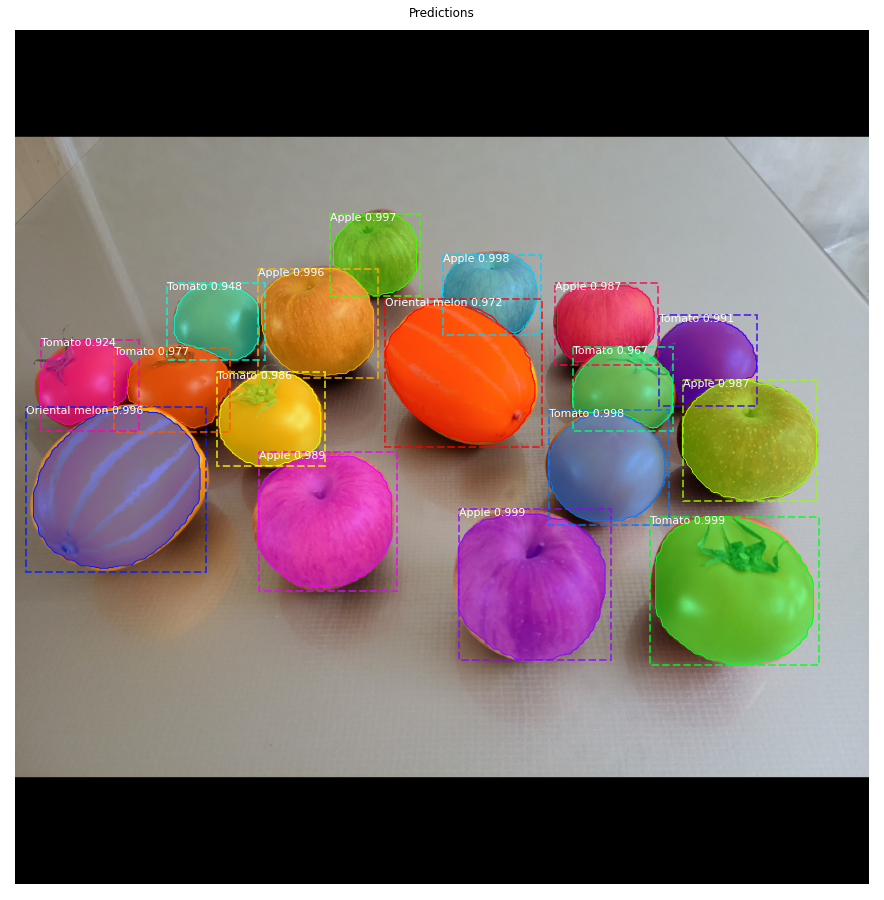

In [22]:
#image_id = random.choice(dataset.image_ids)
image_id = 3
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)